In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

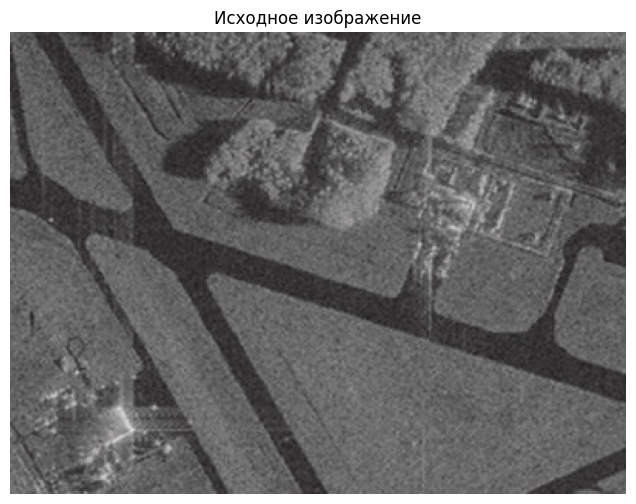

In [ ]:
image = cv2.imread('sar_1.jpg')
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 

plt.figure(figsize=(8, 6))
plt.imshow(image_rgb)
plt.title("Исходное изображение")
plt.axis('off')
plt.show()

Добавлено пикселей: 90
Добавлено пикселей: 295
Добавлено пикселей: 481
Добавлено пикселей: 699
Добавлено пикселей: 867
Добавлено пикселей: 939
Добавлено пикселей: 1139
Добавлено пикселей: 1159
Добавлено пикселей: 1014
Добавлено пикселей: 973
Добавлено пикселей: 949
Добавлено пикселей: 840
Добавлено пикселей: 1139
Добавлено пикселей: 717
Добавлено пикселей: 653
Добавлено пикселей: 616
Добавлено пикселей: 548
Добавлено пикселей: 505
Добавлено пикселей: 441
Добавлено пикселей: 380
Добавлено пикселей: 293
Добавлено пикселей: 285
Добавлено пикселей: 244
Добавлено пикселей: 135
Добавлено пикселей: 5
Добавлено пикселей: 0


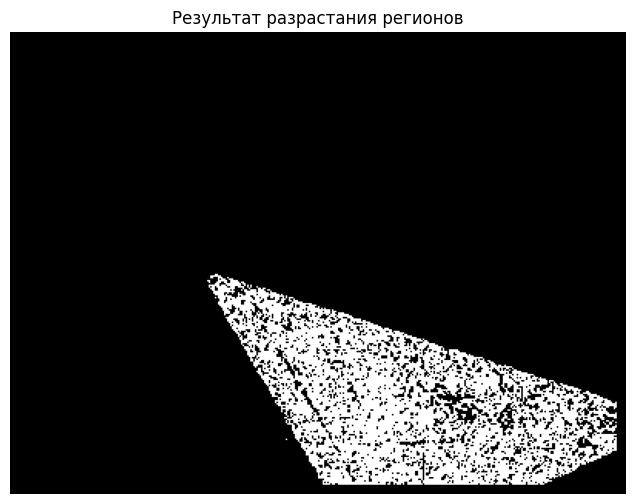

In [8]:
def homo_average(img, mask, point, T):
    av_val = img[mask > 0].sum() / np.count_nonzero(img[mask > 0])
    if abs(av_val - img[point]) <= T:
        return True
    return False

def region_growing(image, seed_point, homo_fun, r, T):
    mask = np.zeros(image_gray.shape, np.uint8)
    mask[seed_point] = 1
    count = 1
    
    while count > 0:
        count = 0
        local_mask = np.zeros(image_gray.shape, np.uint8)
        for i in range(r, image.shape[0] - r):
            for j in range(r, image.shape[1] - r):
                if mask[i,j] == 0 and mask[i - r:i + r, j - r:j + r].sum() > 0:
                    if homo_fun(image, mask, (i,j), T):
                        local_mask[i,j] = 1
        count = np.count_nonzero(local_mask)
        print(f"Добавлено пикселей: {count}")
        mask += local_mask
        
    return mask * 255

# Запуск алгоритма
seed_point = (250, 250)
mask = region_growing(image_gray, seed_point, homo_average, 6, 10)

plt.figure(figsize=(8, 6))
plt.imshow(mask, cmap="gray")
plt.title("Результат разрастания регионов")
plt.axis('off')
plt.show()

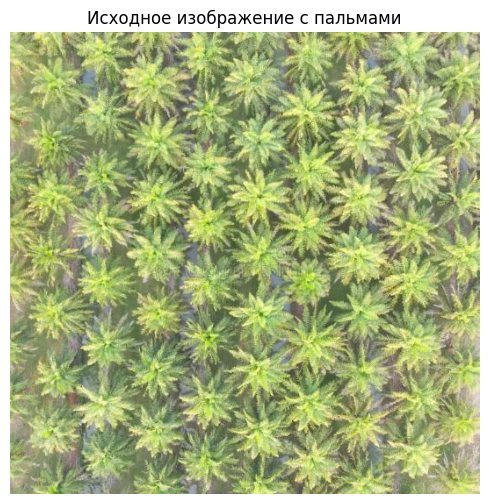

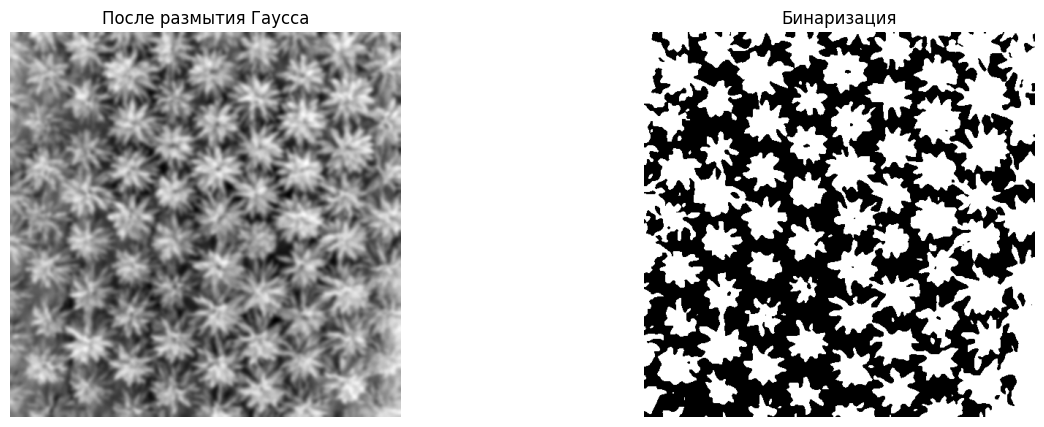

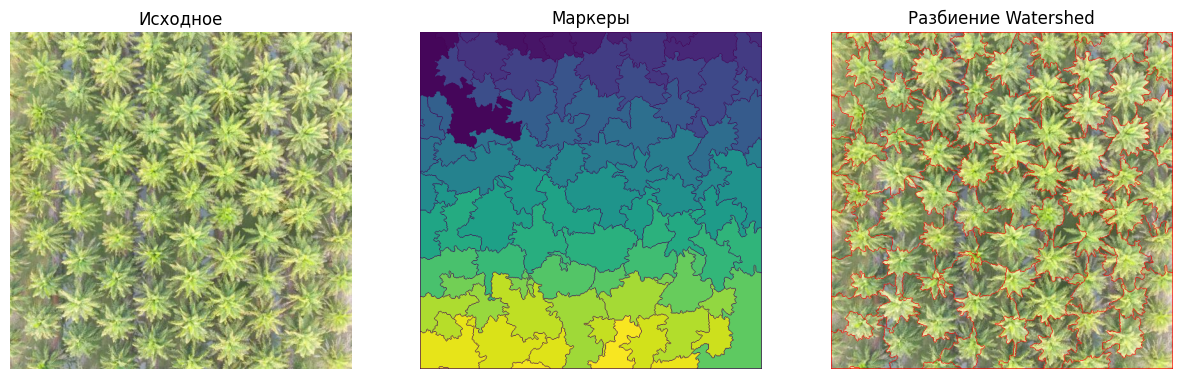

Количество пальмовых деревьев: 100


In [ ]:
image = cv2.imread("palm_1.JPG")
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(8, 6))
plt.imshow(image_rgb)
plt.title("Исходное изображение с пальмами")
plt.axis('off')
plt.show()

blurred = cv2.GaussianBlur(image_gray, (13, 13), 0)
ret, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.imshow(blurred, cmap='gray')
plt.title('После размытия Гаусса')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(thresh, cmap='gray')
plt.title('Бинаризация')
plt.axis('off')
plt.show()

dist = cv2.distanceTransform(thresh, cv2.DIST_L2, 5) 
ret, sure_fg = cv2.threshold(dist, 0.2 * dist.max(), 255, cv2.THRESH_BINARY) 
sure_fg = sure_fg.astype(np.uint8)
ret, markers = cv2.connectedComponents(sure_fg)

res_image = image.copy()
markers = cv2.watershed(res_image, markers.astype(np.int32)) 
res_image[markers == -1] = [0, 0, 255] 

palm_count = len(np.unique(markers)) - 1

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Исходное")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(markers)
plt.title("Маркеры")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(res_image, cv2.COLOR_BGR2RGB))
plt.title("Разбиение Watershed")
plt.axis('off')
plt.show()

print(f"Количество пальмовых деревьев: {palm_count}")

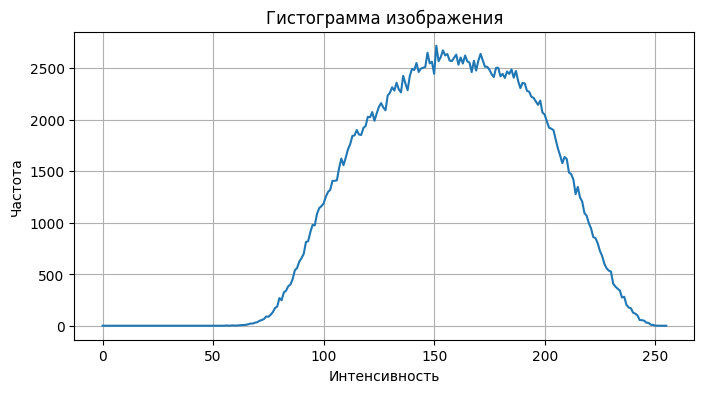

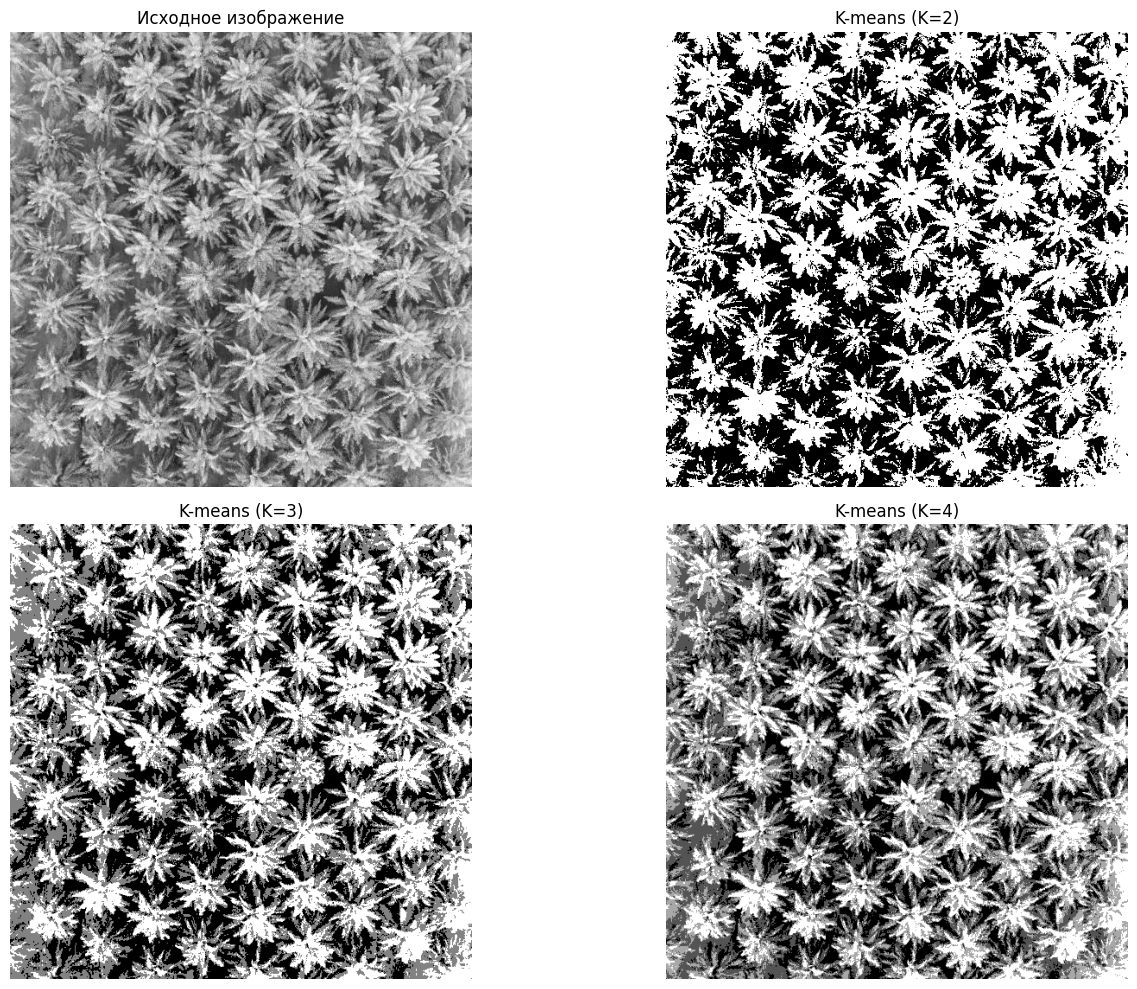

Сравнение результатов K-means:
- K=2: Два основных класса (светлые/темные области)
- K=3: Более детальная сегментация
- K=4: Наиболее детальная сегментация


In [ ]:
def apply_kmeans(image, K):
    z = image.reshape((-1, 1))  
    z = np.float32(z)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    ret, label, center = cv2.kmeans(z, K, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    center = np.uint8(center)
    res = center[label.flatten()]
    res2 = res.reshape((image.shape))
    return res2

def make_hist(image):
    histSize = 256
    histRange = (0, 256)
    accumulate = False
    return cv2.calcHist([image], [0], None, [histSize], histRange, accumulate=accumulate)


hist = make_hist(image_gray)
plt.figure(figsize=(8, 4))
plt.plot(hist)
plt.title('Гистограмма изображения')
plt.xlabel('Интенсивность')
plt.ylabel('Частота')
plt.grid(True)
plt.show()

k2_result = apply_kmeans(image_gray, 2)
k3_result = apply_kmeans(image_gray, 3)
k4_result = apply_kmeans(image_gray, 4)

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes[0, 0].imshow(image_gray, cmap='gray')
axes[0, 0].set_title('Исходное изображение')
axes[0, 0].axis('off')

axes[0, 1].imshow(k2_result, cmap='gray')
axes[0, 1].set_title('K-means (K=2)')
axes[0, 1].axis('off')

axes[1, 0].imshow(k3_result, cmap='gray')
axes[1, 0].set_title('K-means (K=3)')
axes[1, 0].axis('off')

axes[1, 1].imshow(k4_result, cmap='gray')
axes[1, 1].set_title('K-means (K=4)')
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

print("Сравнение результатов K-means:")
print("- K=2: Два основных класса (светлые/темные области)")
print("- K=3: Более детальная сегментация")  
print("- K=4: Наиболее детальная сегментация")

In [12]:
print("=== ВЫПОЛНЕНИЕ ЗАДАНИЙ ===")
print("\n1. Алгоритм разрастания регионов:")
print("   - Реализован с критерием однородности по среднему")
print("   - Параметры: seed_point=(250,250), r=6, T=10")

print("\n2. Новый критерий однородности:")
print("   - K-means кластеризация как альтернативный метод")
print("   - Сравнение для K=2,3,4 кластеров")

print("\n3. Watershed для подсчета пальм:")
print(f"   - Обнаружено пальмовых деревьев: {palm_count}")
print("   - Использован Distance Transform для улучшения сегментации")

=== ВЫПОЛНЕНИЕ ЗАДАНИЙ ===

1. Алгоритм разрастания регионов:
   - Реализован с критерием однородности по среднему
   - Параметры: seed_point=(250,250), r=6, T=10

2. Новый критерий однородности:
   - K-means кластеризация как альтернативный метод
   - Сравнение для K=2,3,4 кластеров

3. Watershed для подсчета пальм:
   - Обнаружено пальмовых деревьев: 100
   - Использован Distance Transform для улучшения сегментации
